# test.csv 데이터 구조 및 기초 탐색 (EDA)

이 노트북에서는 **대구 공공데이터 시각화 프로젝트**에서 사용되는  
`test.csv` 파일에 대해 다음 내용을 실습합니다.

1. `test.csv` 파일 로드 및 상위 10행(`head(10)`) 확인  
2. 전체 행 수, 전체 컬럼 수, 평균 결측값 비율 계산  
3. `df.info()`를 통한 전체 스키마 구조 확인  
4. **수치형 / 범주형 컬럼 분리**  
5. 수치형 컬럼 기초 통계량(`describe()`) 확인  
6. **모든 수치형 / 범주형 컬럼에 대한 히스토그램(또는 bar chart) 시각화**

이 노트북 역시 이후 Streamlit 대시보드 화면 구성을  
Colab에서 미리 검증하기 위한 용도입니다.


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 42 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (10.7 MB/s)
Selecting previously unselected package fonts-nanum.
(Reading database ... 121713 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
matplotlibrc 경로: /usr/local/lib/py

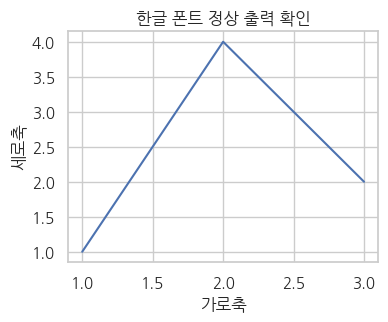

In [ ]:
# ==========================================
# 1. 한글 출력을 위한 기초 셀
#    (코랩에서 한 번만 실행하면 이후 그래프에 한글이 깨지지 않도록 설정)
# ==========================================

!apt-get update -qq
!apt-get install -y fonts-nanum

import matplotlib as mpl
print("matplotlibrc 경로:", mpl.matplotlib_fname())

import shutil
import matplotlib as mpl

# matplotlib 설정 파일(matplotlibrc)의 경로에서 루트 디렉토리만 추출
# 예) /usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/matplotlibrc
#  → /usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/
root = mpl.matplotlib_fname().replace("matplotlibrc", "")

# matplotlib 기본 폰트 파일(DejaVuSans.ttf)이 위치한 경로
target_font = root + "fonts/ttf/DejaVuSans.ttf"
print("matplotlib 기본 폰트 파일:", target_font)

# 나눔고딕 폰트 경로 (Ubuntu/Colab에서 설치되는 경로)
nanum_font = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"

# DejaVuSans.ttf 파일을 나눔고딕으로 교체하여
# matplotlib의 기본 폰트를 나눔고딕으로 설정
shutil.copyfile(nanum_font, target_font)
print("기본 폰트를 나눔고딕으로 교체 완료")

# matplotlib 캐시 삭제 (새 폰트 강제 적용)
!rm -rf ~/.cache/matplotlib

import matplotlib.pyplot as plt
import seaborn as sns

# seaborn 스타일을 'whitegrid'로 지정 (흰 배경 + 그리드)
sns.set(style="whitegrid")

# 테스트 플롯 (한글 출력 확인)
plt.figure(figsize=(4,3))
plt.title("한글 폰트 정상 출력 확인")
plt.xlabel("가로축")
plt.ylabel("세로축")
plt.plot([1,2,3], [1,4,2])
plt.show()

In [ ]:
# ==========================================
# 2. 기본 라이브러리 임포트
# ==========================================
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# 그래프 크기 및 폰트 기본 설정
plt.rcParams["figure.figsize"] = (8, 4)
plt.rcParams["axes.unicode_minus"] = False  # 마이너스 깨짐 방지


## 3. test.csv 파일 로드

`test.csv`는 다음 방식으로 불러옵니다.

1. **Colab에서 직접 파일 업로드**  
   - 실습 참여자가 각자 로컬에 있는 `test.csv`를 업로드  
2. (선택) 구글 드라이브 마운트 후 경로를 지정해 로드  

여기서는 가장 간단한 **직접 업로드 방식**을 사용합니다.


In [ ]:
# ==========================================
# 3. test.csv 업로드 및 로드
# ==========================================
from google.colab import files

print("test.csv 파일을 선택해서 업로드 해주세요.")
uploaded = files.upload()  # 파일 선택 창

# 업로드된 파일 이름 확인
print("업로드된 파일 목록:", list(uploaded.keys()))

# 일반적으로 파일 이름이 'test.csv' 라고 가정
file_name = list(uploaded.keys())[0]  # 첫 번째 업로드 파일 사용
print("사용할 파일 이름:", file_name)

# 인코딩을 여러 개 시도하는 헬퍼 함수 정의
def read_csv_safe(path, encodings=["utf-8", "utf-8-sig", "cp949"]):
    """
    여러 인코딩을 시도하면서 CSV 파일을 안전하게 읽기 위한 함수.
    """
    last_error = None
    for enc in encodings:
        try:
            return pd.read_csv(path, encoding=enc)
        except Exception as e:
            last_error = e
            print(f"[경고] 인코딩 {enc} 로 읽기 실패: {e}")
            continue
    raise ValueError(f"CSV를 어떤 인코딩으로도 읽을 수 없습니다. 마지막 에러: {last_error}")

# 실제 데이터 로드
df = read_csv_safe(file_name)

print("데이터 로딩 완료!")
print("데이터 형태 (행, 열):", df.shape)


test.csv 파일을 선택해서 업로드 해주세요.


Saving test.csv to test.csv
업로드된 파일 목록: ['test.csv']
사용할 파일 이름: test.csv
데이터 로딩 완료!
데이터 형태 (행, 열): (10963, 8)


In [ ]:
# ==========================================
# 4. 데이터 상위 10행 및 기본 요약 정보
# ==========================================

# 상위 10행 출력
print("=== test 데이터 상위 10행 (head(10)) ===")
display(df.head(10))

# 전체 행/열 수 및 평균 결측값 비율 계산
print("\n=== test 데이터 기본 요약 ===")
total_rows = df.shape[0]
total_cols = df.shape[1]
missing_ratio = df.isnull().mean().mean() * 100  # 전체 평균 결측 비율 %

print(f"전체 행 수: {total_rows:,}")
print(f"전체 컬럼 수: {total_cols:,}")
print(f"평균 결측값 비율: {missing_ratio:.2f}%")

# (참고: 현재 데이터 기준 기대 값 예시)
# 전체 행 수: 10,963
# 전체 컬럼 수: 8
# 평균 결측값 비율: 0.00%


=== test 데이터 상위 10행 (head(10)) ===


,ID,사고일시,요일,기상상태,시군구,도로형태,노면상태,사고유형
0,ACCIDENT_39609,2022-01-01 01,토요일,맑음,대구광역시 수성구 상동,교차로 - 교차로안,건조,차대사람
1,ACCIDENT_39610,2022-01-01 01,토요일,맑음,대구광역시 수성구 지산동,단일로 - 기타,건조,차대사람
2,ACCIDENT_39611,2022-01-01 04,토요일,맑음,대구광역시 수성구 수성동2가,교차로 - 교차로안,건조,차대차
3,ACCIDENT_39612,2022-01-01 04,토요일,맑음,대구광역시 수성구 신매동,단일로 - 기타,건조,차대차
4,ACCIDENT_39613,2022-01-01 06,토요일,맑음,대구광역시 달서구 감삼동,교차로 - 교차로안,건조,차대차
5,ACCIDENT_39614,2022-01-01 12,토요일,맑음,대구광역시 중구 달성동,단일로 - 기타,건조,차대차
6,ACCIDENT_39615,2022-01-01 13,토요일,맑음,대구광역시 동구 신암동,교차로 - 교차로안,건조,차대차
7,ACCIDENT_39616,2022-01-01 13,토요일,맑음,대구광역시 서구 평리동,교차로 - 교차로횡단보도내,건조,차대사람
8,ACCIDENT_39617,2022-01-01 15,토요일,맑음,대구광역시 달서구 송현동,단일로 - 기타,건조,차대차
9,ACCIDENT_39618,2022-01-01 15,토요일,맑음,대구광역시 달서구 두류동,교차로 - 교차로안,건조,차대차



=== test 데이터 기본 요약 ===
전체 행 수: 10,963
전체 컬럼 수: 8
평균 결측값 비율: 0.00%


In [ ]:
# ==========================================
# 5. df.info()로 전체 스키마 확인
# ==========================================

print("=== test 데이터 info() ===")
df.info()


=== test 데이터 info() ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10963 entries, 0 to 10962
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      10963 non-null  object
 1   사고일시    10963 non-null  object
 2   요일      10963 non-null  object
 3   기상상태    10963 non-null  object
 4   시군구     10963 non-null  object
 5   도로형태    10963 non-null  object
 6   노면상태    10963 non-null  object
 7   사고유형    10963 non-null  object
dtypes: object(8)
memory usage: 685.3+ KB


## 6. 수치형 / 범주형 컬럼 분리

train과 마찬가지로,  
`test.csv`에서도 **수치형 / 범주형 컬럼을 자동으로 분리**해 봅니다.

> 이 데이터셋은 수치형 컬럼이 없을 가능성이 높지만,  
> 코드 구조를 통일하기 위해 동일한 로직을 적용합니다.


In [ ]:
# ==========================================
# 6. 수치형 / 범주형 컬럼 분리
# ==========================================

# 수치형 컬럼: int, float 계열
numeric_cols = df.select_dtypes(include=["int64", "float64", "int32", "float32"]).columns.tolist()

# 범주형 컬럼: object, category, bool 계열
categorical_cols = df.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

print("=== 수치형 컬럼 목록 ===")
print(numeric_cols)

print("\n=== 범주형 컬럼 목록 ===")
print(categorical_cols)

# 교육용 메시지 추가
if len(numeric_cols) == 0:
    print("\n[알림] 이 데이터셋에는 수치형 컬럼이 없습니다. (또는 자동 인식되지 않았습니다.)")


=== 수치형 컬럼 목록 ===
[]

=== 범주형 컬럼 목록 ===
['ID', '사고일시', '요일', '기상상태', '시군구', '도로형태', '노면상태', '사고유형']

[알림] 이 데이터셋에는 수치형 컬럼이 없습니다. (또는 자동 인식되지 않았습니다.)


## 7. 수치형 컬럼 기초 통계량(describe)

수치형 컬럼이 있다면 `describe()`로 기본 통계량을 확인합니다.  
`test.csv`에는 수치형 컬럼이 없을 수 있으므로,  
그 경우에는 안내 문구만 출력되도록 합니다.


In [ ]:
# ==========================================
# 7. 수치형 컬럼 기초 통계량(describe)
# ==========================================

if len(numeric_cols) > 0:
    print("=== 수치형 컬럼 기초 통계량 (describe) ===")
    display(df[numeric_cols].describe().T)
else:
    print("수치형 컬럼이 없어 describe()를 출력하지 않습니다.")


수치형 컬럼이 없어 describe()를 출력하지 않습니다.


## 8. 수치형 / 범주형 컬럼 시각화

1. 수치형 컬럼이 있다면:  
   - 각 컬럼별 히스토그램 + KDE(밀도 곡선)를 그립니다.  

2. 범주형 컬럼에 대해서는:  
   - 각 컬럼의 **상위 N개 카테고리**에 대한 bar chart를 그립니다.  

`test.csv`에서는 수치형 컬럼이 없을 가능성이 높기 때문에  
실제로는 범주형 컬럼 시각화만 실행될 수 있습니다.


In [ ]:
# ==========================================
# 8-1. 모든 수치형 컬럼 히스토그램
# ==========================================

if len(numeric_cols) == 0:
    print("수치형 컬럼이 없어 히스토그램을 그릴 수 없습니다.")
else:
    for col in numeric_cols:
        plt.figure(figsize=(6, 4))
        sns.histplot(data=df, x=col, kde=True, bins=30)
        plt.title(f"[수치형] {col} 히스토그램")
        plt.xlabel(col)
        plt.ylabel("빈도수")
        plt.tight_layout()
        plt.show()


수치형 컬럼이 없어 히스토그램을 그릴 수 없습니다.


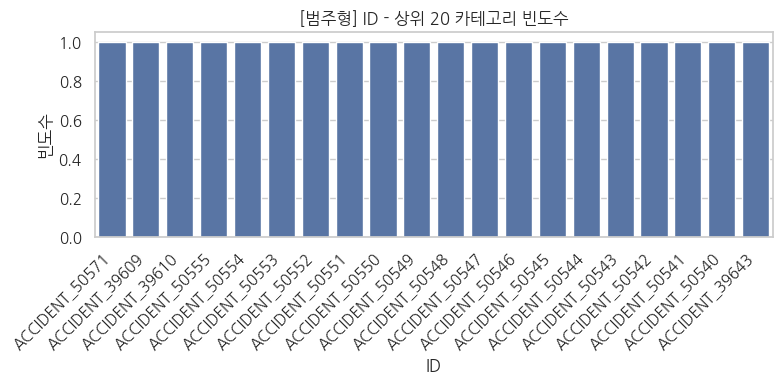

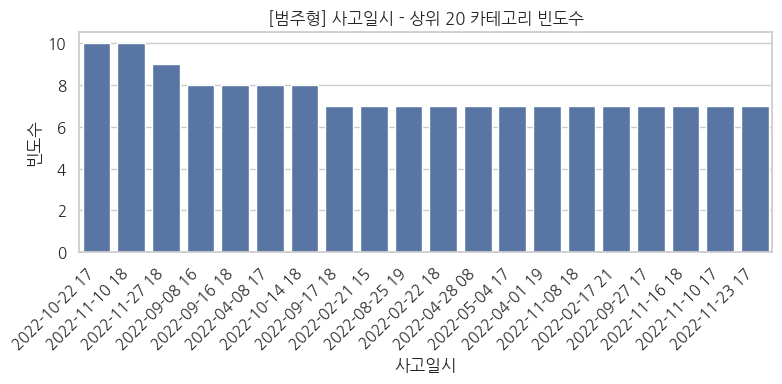

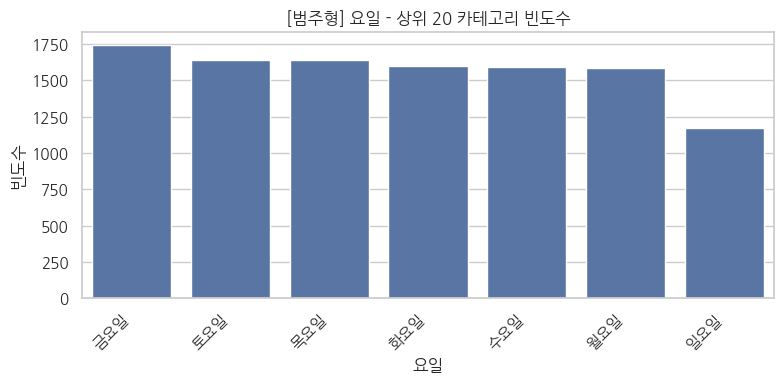

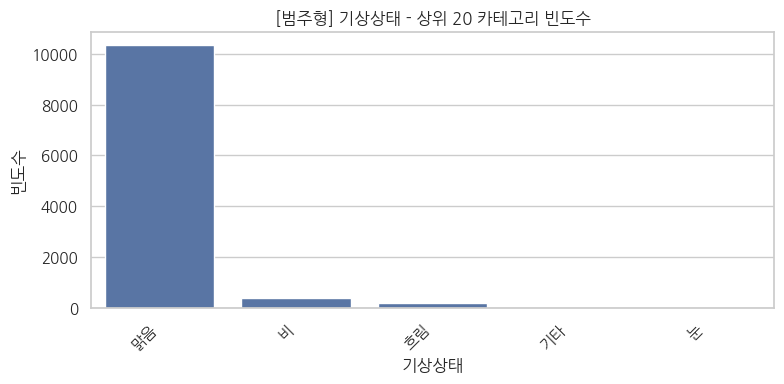

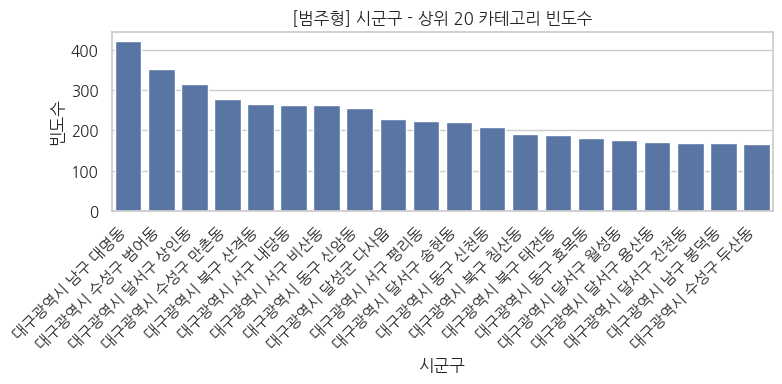

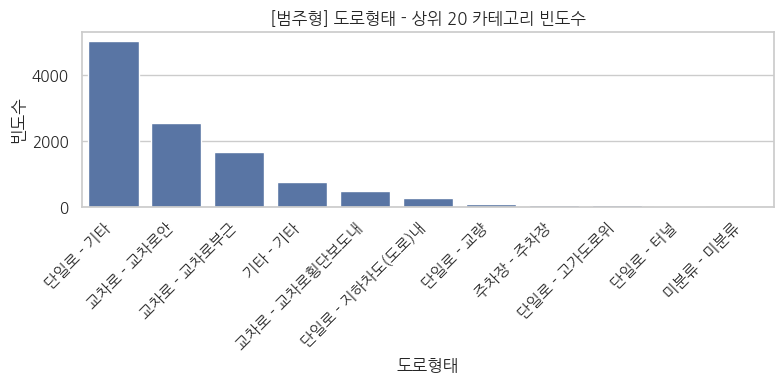

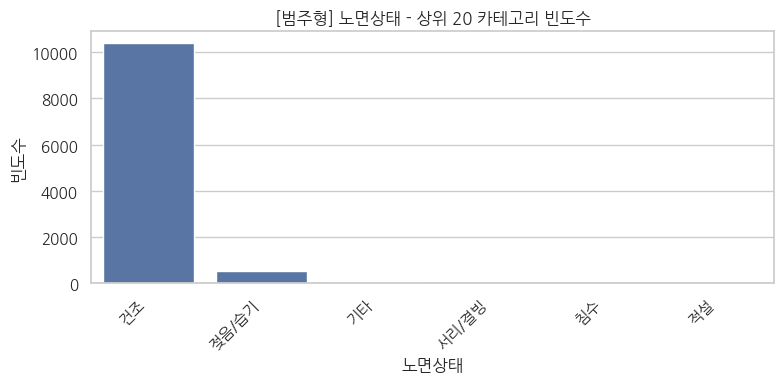

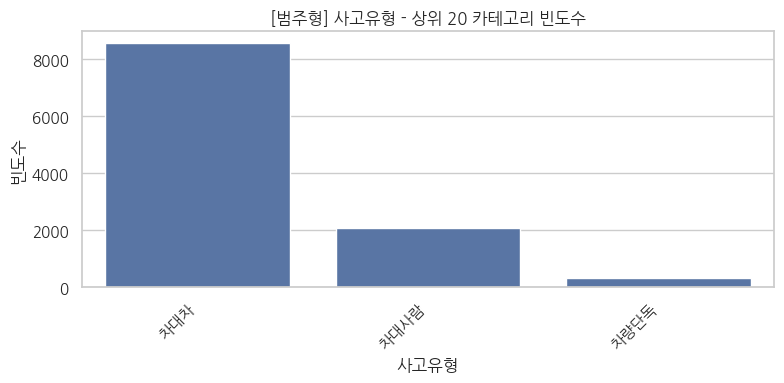

In [ ]:
# ==========================================
# 8-2. 모든 범주형 컬럼 bar chart
# ==========================================

TOP_N = 20  # 상위 몇 개 카테고리까지 볼지 설정

if len(categorical_cols) == 0:
    print("범주형 컬럼이 없어 bar chart를 그릴 수 없습니다.")
else:
    for col in categorical_cols:
        value_counts = df[col].value_counts().head(TOP_N)

        plt.figure(figsize=(8, 4))
        sns.barplot(x=value_counts.index.astype(str),
                    y=value_counts.values)
        plt.title(f"[범주형] {col} - 상위 {TOP_N} 카테고리 빈도수")
        plt.xlabel(col)
        plt.ylabel("빈도수")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()


## 9. AI 화면 구현과 다른 점